# Notebook 3: Data Cleaning & Preprocessing (Heart Disease Dataset)

---

This notebook focuses on **cleaning and preparing the dataset** for modeling.

The main steps are:

1. Import libraries and dataset  
   
2. Basic EDA (explore missing values, invalid zeros, datatypes)  
   
- Refined missingness policy (visual + thresholds)  
  
3. Drop or keep columns based on missingness  
   
4. Impute missing values (median/mode)  
   
5. Encode categorical variables  
   
6. Log decisions for transparency  
   
7. Save cleaned dataset for use in later notebooks  

---

## Step 1. Load Raw Dataset

Step Purpose

We begin by loading the unmodified dataset saved in **Notebook 1**. This ensures that cleaning steps are reproducible and independent from exploratory work.

Approach

- Use `pd.read_csv()` to load the dataset.
- Display shape and first few rows to confirm load.

Expected Outcome

Dataset loaded with no changes, matching exactly the saved raw version.

In [33]:
import os
import pandas as pd
from pathlib import Path

input_path = Path("/workspaces/Heart_disease_risk_predictor/inputs/datasets/raw/heart_disease_uci.csv")
df = pd.read_csv(input_path)

print(f"Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")
df.head()



Dataset loaded: 920 rows × 16 columns


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


---

## Step 2. Initial EDA

We start by inspecting:
- Dataset shape (rows, columns)  
- Data types (numeric vs categorical)  
- Basic statistics  
- Count of missing values (NaNs)  

This gives us a first impression before applying our cleaning policy.  

In [25]:
# Shape and types
print(df.info())

# Basic stats
display(df.describe(include='all').transpose())

# Count missing
print("\nMissing values per column (raw):\n", df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB
None


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,920.0,NaN,NaN,NaN,460.5,265.725422,1.0,230.75,460.5,690.25,920.0
age,920.0,NaN,NaN,NaN,53.51087,9.424685,28.0,47.0,54.0,60.0,77.0
sex,920,2,Male,726,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dataset,920,4,Cleveland,304,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cp,920,4,asymptomatic,496,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trestbps,861.0,NaN,NaN,NaN,132.132404,19.06607,0.0,120.0,130.0,140.0,200.0
chol,890.0,NaN,NaN,NaN,199.130337,110.78081,0.0,175.0,223.0,268.0,603.0
fbs,830,2,False,692,NaN,NaN,NaN,NaN,NaN,NaN,NaN
restecg,918,3,normal,551,NaN,NaN,NaN,NaN,NaN,NaN,NaN
thalch,865.0,NaN,NaN,NaN,137.545665,25.926276,60.0,120.0,140.0,157.0,202.0



Missing values per column (raw):
 id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64


## Step 2.5 — Re-check Missingness After Replacing Invalid Zeros

Before deciding whether to drop or impute, we need to make sure that our missingness statistics reflect reality.  
In this dataset, some features (like `trestbps` and `chol`) have **invalid zero values**.  
We first replace those zeros with `NaN`, then recalculate missing percentages.

This lets us:
- Identify which features are safe to impute,  
- Which ones require caution, and  
- Which ones should be dropped due to too much missing data.  

We also visualize the distribution of missing values by column, color-coded by severity:

- Green = Safe to impute (≤ 5%)  
- Orange = Caution (5–25%)  
- Red = Likely drop (> 25%)  

✅ Low missing (<=5%) — safe to impute:
 restecg    0.217391
age        0.000000
id         0.000000
sex        0.000000
dataset    0.000000
cp         0.000000
num        0.000000
dtype: float64 

⚠️ Medium missing (5–25%) — caution:
 chol        21.956522
fbs          9.782609
oldpeak      6.739130
trestbps     6.521739
thalch       5.978261
exang        5.978261
dtype: float64 

❌ High missing (>25%) — consider dropping:
 ca       66.413043
thal     52.826087
slope    33.586957
dtype: float64 



/tmp/ipykernel_669/3949064940.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


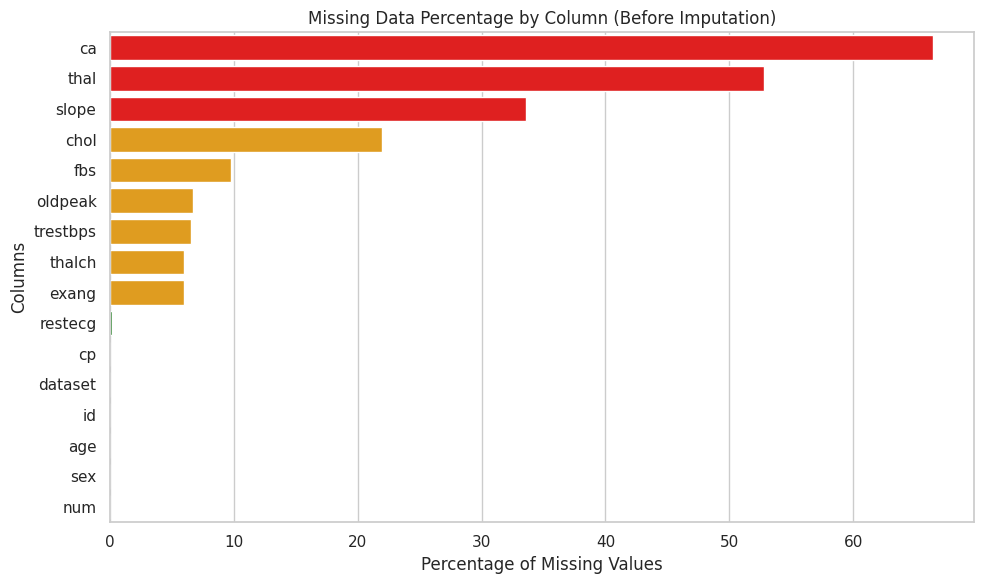

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Replace invalid zeros (do this once, before missingness decisions) ---
for col in ['trestbps', 'chol']:
    if col in df.columns:
        df[col] = df[col].replace(0, np.nan)

# --- BEFORE-IMPUTATION CHECK: % missing values ---
missing_percent = (df.isna().sum() / len(df)) * 100

# Policy thresholds
low_threshold = 5      # Safe to impute
high_threshold = 25    # Drop above this (unless whitelisted)

# Buckets
low_missing    = missing_percent[missing_percent <= low_threshold]
medium_missing = missing_percent[(missing_percent > low_threshold) & (missing_percent <= high_threshold)]
high_missing   = missing_percent[missing_percent > high_threshold]

print("✅ Low missing (<=5%) — safe to impute:\n", low_missing.sort_values(ascending=False), "\n")
print("⚠️ Medium missing (5–25%) — caution:\n", medium_missing.sort_values(ascending=False), "\n")
print("❌ High missing (>25%) — consider dropping:\n", high_missing.sort_values(ascending=False), "\n")

# --- VISUALIZATION ---
plt.figure(figsize=(10, 6))
ordered = missing_percent.sort_values(ascending=False)
sns.barplot(
    x=ordered.values,
    y=ordered.index,
    palette=[
        "red" if val > high_threshold else "orange" if val > low_threshold else "green"
        for val in ordered.values
    ]
)
plt.xlabel("Percentage of Missing Values")
plt.ylabel("Columns")
plt.title("Missing Data Percentage by Column (Before Imputation)")
plt.tight_layout()
plt.show()

---

## Step 3 — Drop or Keep Columns Based on Missingness Policy

We now apply a **decision policy** to each feature:

- **Drop features** if missing > 25% (too unreliable for imputation).  
- **Keep and impute** if ≤ 25%.  
- **Allow exceptions**: Some features (like `chol`) are too clinically important to discard, even if missingness is borderline. These are *whitelisted* in a `force_keep` list.

This balances:
- Preserving medically valuable predictors,  
- Avoiding unrealistic imputation of large data gaps.  

In [3]:
# Columns to DROP (missing% > 25), unless explicitly protected
to_drop = set(high_missing.index.tolist())

# Explicit exceptions to KEEP (force whitelist)
force_keep = {"chol"}

# Apply whitelist
to_drop = [c for c in to_drop if c not in force_keep]

print(f"Columns to DROP (> {high_threshold}% missing, excluding exceptions): {to_drop}")

# Drop them
df = df.drop(columns=to_drop)

Columns to DROP (> 25% missing, excluding exceptions): ['thal', 'slope', 'ca']


---

## Step 4 — Impute Missing Values in Remaining Columns

After dropping high-missing features, we handle missing values in the remaining columns:  

- **Numeric features** → imputed with the **median** (robust against skew/outliers).  
- **Categorical features** → imputed with the **mode** (most frequent value).  

We re-check missingness after imputation to ensure that the dataset has no `NaN` values left.  

In [4]:
# Recompute missing after drops
missing_percent_postdrop = (df.isna().sum() / len(df)) * 100
remaining_missing_cols = missing_percent_postdrop[missing_percent_postdrop > 0].index.tolist()

# Split numeric vs categorical
num_cols = df.select_dtypes(include='number').columns.tolist()
cat_cols = df.select_dtypes(exclude='number').columns.tolist()

# Exclude target column 'num' from imputation
if 'num' in num_cols:
    num_cols_wo_target = [c for c in num_cols if c != 'num']
else:
    num_cols_wo_target = num_cols[:]

# Impute
for col in remaining_missing_cols:
    if col in num_cols_wo_target:
        df[col] = df[col].fillna(df[col].median())
    elif col in cat_cols:
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

# Confirm no NaNs remain
print("Remaining missing after imputation:\n", df.isna().sum().sort_values(ascending=False))

Remaining missing after imputation:
 id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
num         0
dtype: int64


---

## Step 5 — Encode Categorical Variables

Machine learning models require numerical input.  
We therefore convert categorical features into **dummy variables** using **one-hot encoding**:

- Each category becomes a new binary column (1 if present, 0 if not).  
- We use `drop_first=True` to avoid dummy-variable trap (perfect collinearity).  

The target column `num` is **not encoded** — it remains intact for modeling. 

In [16]:
# Identify categorical variables
cat_cols = df.select_dtypes(include='object').columns.tolist()

# Apply one-hot encoding
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
print("✅ One-hot encoding complete!\n")

# 1️⃣ Shape check
print(f"Original shape: {df.shape}")
print(f"Encoded shape:  {df_encoded.shape}\n")

# 2️⃣ Confirm original categorical columns are gone
remaining_cats = [c for c in cat_cols if c in df_encoded.columns]
if not remaining_cats:
    print("✅ All original categorical columns have been encoded.")
else:
    print("⚠️ These categorical columns were not encoded:", remaining_cats)

# 3️⃣ Show new columns created
new_cols = set(df_encoded.columns) - set(df.columns)
print(f"\nNew dummy columns created ({len(new_cols)}):\n", sorted(new_cols))

# 4️⃣ Spot-check all rows of the encoded dataframe
pd.set_option('display.max_rows', None)   # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns if needed
print(df_encoded)

✅ One-hot encoding complete!

Original shape: (920, 13)
Encoded shape:  (920, 18)

✅ All original categorical columns have been encoded.

New dummy columns created (9):
 ['cp_atypical angina', 'cp_non-anginal', 'cp_typical angina', 'dataset_Hungary', 'dataset_Switzerland', 'dataset_VA Long Beach', 'restecg_normal', 'restecg_st-t abnormality', 'sex_Male']
      id  age  trestbps   chol    fbs  thalch  exang  oldpeak  num  sex_Male  \
0      1   63     145.0  233.0   True   150.0  False      2.3    0      True   
1      2   67     160.0  286.0  False   108.0   True      1.5    2      True   
2      3   67     120.0  229.0  False   129.0   True      2.6    1      True   
3      4   37     130.0  250.0  False   187.0  False      3.5    0      True   
4      5   41     130.0  204.0  False   172.0  False      1.4    0     False   
5      6   56     120.0  236.0  False   178.0  False      0.8    0      True   
6      7   62     140.0  268.0  False   160.0  False      3.6    3     False   
7  

---

## Step 6 — Log Cleaning Decisions

Finally, we create a **summary log** of all preprocessing steps:  

- Which columns had invalid zeros replaced  
- Thresholds used for missingness  
- Which columns were dropped  
- Which were forced to be kept  
- How imputation was applied  
- Which categorical variables were encoded  
- Final dataset shape  

This ensures transparency and reproducibility.  

In [17]:
decisions = {
    "invalid_zero_to_nan": ['trestbps', 'chol'],
    "policy_low_threshold_percent": low_threshold,
    "policy_high_threshold_percent": high_threshold,
    "dropped_columns": to_drop,
    "force_kept_columns": list(force_keep),
    "imputation_numeric": "median",
    "imputation_categorical": "mode",
    "encoded_columns": cat_cols,
    "final_shape": df_encoded.shape,
}

print("=== CLEANING DECISIONS SUMMARY ===")
for k, v in decisions.items():
    print(f"- {k}: {v}")

=== CLEANING DECISIONS SUMMARY ===
- invalid_zero_to_nan: ['trestbps', 'chol']
- policy_low_threshold_percent: 5
- policy_high_threshold_percent: 25
- dropped_columns: ['thal', 'slope', 'ca']
- force_kept_columns: ['chol']
- imputation_numeric: median
- imputation_categorical: mode
- encoded_columns: ['sex', 'dataset', 'cp', 'restecg']
- final_shape: (920, 18)


---

## Step 7 — Save Cleaned Dataset

We save the cleaned dataset into the **processed folder** for downstream modeling (Notebook 4).  

In [34]:
# --- Create folders if they don't exist ---
os.makedirs("outputs/datasets/cleaned", exist_ok=True)
os.makedirs("outputs/figures/data_cleaning", exist_ok=True)

# --- Function to save figures into the data_cleaning folder ---
def save_figure(fig, filename):
    fig.savefig(f"outputs/figures/data_cleaning/{filename}", bbox_inches="tight")
    plt.close(fig)  # Close figure to free memory

# --- Save cleaned dataset ---
df.to_csv("outputs/datasets/cleaned/heart_disease_cleaned.csv", index=False)
print("✅ Cleaned dataset saved: outputs/datasets/cleaned/heart_disease_cleaned.csv")

✅ Cleaned dataset saved: outputs/datasets/cleaned/heart_disease_cleaned.csv
